# Image Reconstruction using Deep Autoencoders

Here, I will investigate if we can use autoencoders to reconstruct MNIST data that has been encoded with coded aperture.   
**Research Question:** Given a coded image, can we recover the decoding pattern?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.fft import fft2, ifft2, fft, ifft

import torchvision.transforms as transforms
from torchvision import datasets
import torch
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from CNN import CNN
import confusion_matrix as cm

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    #"figure.figsize" : [15,10],
})

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Load MNIST Data

## Hyperparameters

In [12]:
# define hyperparameters
params = {
 # "dataset": "MNIST",
 # "machine": "desktop",
  "model": "NN",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 200,
}
wandb.config = params

# Compute MURA encoder and decoder
p = 23 # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

## Transform data

In [6]:
# Define the size of MNIST image to be equal to the size of A 
size = A.shape[0]
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    # Apply MURA encoder
                    # transforms.Lambda(lambda x: torch.unsqueeze(torch.tensor(
                    #     mura.FFT_convolve(np.squeeze(x.numpy()), A,size), dtype= torch.float), 0)),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)

test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    # Apply MURA encoder
                    # transforms.Lambda(lambda x: torch.unsqueeze(torch.tensor(
                    #     mura.FFT_convolve(np.squeeze(x.numpy()), A,size), dtype= torch.float), 0)),
                    transforms.Normalize(0, 1)
                ]) 
)

In [27]:
%%time
# Define lists to save encoded image and original image data
mura_train_data = []
mura_test_data  = []

# Store training data
for idx in range(len(train_data)):
    img_label_list = list(train_data[idx])
    
    # Data will be saved as a tuple of (encoded image, original image) where we will use original image as labels
    img_label_list[0] = torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(train_data[idx][0].numpy()), A,size), dtype= torch.float), 0)
    img_label_list[1] = train_data[idx][0]
    mura_train_data.append(tuple(img_label_list))

# Store test data
for idx in range(len(test_data)):
    img_label_list = list(test_data[idx])
    
    # Data will be saved as a tuple of (encoded image, original image) where we will use original image as labels
    img_label_list[0] = torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(test_data[idx][0].numpy()), A,size), dtype= torch.float), 0)
    img_label_list[1] = test_data[idx][0]
    mura_test_data.append(tuple(img_label_list))

print("Done!")

Done!
CPU times: user 1min 8s, sys: 1.61 s, total: 1min 10s
Wall time: 1min 11s


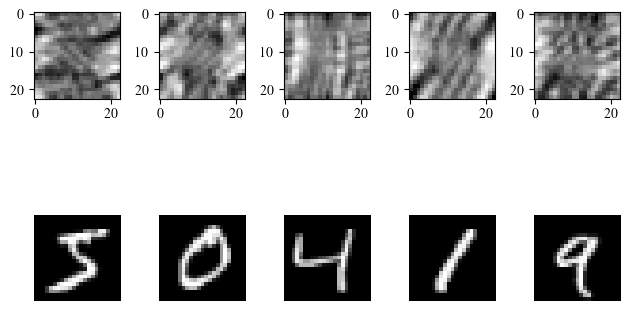

In [8]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(mura_train_data), (5))
  
for idx in range(random_samples.shape[0]):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(mura_train_data[idx][0][0].numpy(), cmap='gray')
    plt.subplot(2, 5, idx + 6)
    plt.imshow(mura_train_data[idx][1][0].numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
loaders = {
    'train' : torch.utils.data.DataLoader(mura_train_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(mura_test_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=False, 
                                          num_workers=0),
}

# Define Model

In [13]:
class NN(torch.nn.Module):
    def __init__(self, img_size):
        super().__init__()  
        self.img_size = img_size
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.img_size * self.img_size, self.img_size * self.img_size),
        )
    def forward(self, x):
        output = self.model(x)
        return output

In [14]:
# Instantiate model 
model = NN(size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate']) 
PATH = f'../models/NN_mnist_{params["epochs"]}epochs.pth'

# Training

In [15]:
%%time

# Initialize project in Weights and Biases
wandb.init(project="coded-aperture-MNIST", group="NN")

# Store values for later (training loss for now)
train_loss = []

#Dictionary that will store different images and outputs for various epochs (not sure if needed)
outputs = {}

# Training loop starts
for epoch in range(params['epochs']):
    
    # Initialize variable to store loss
    running_loss = 0
    
    # Iterate over training set
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [images, labels]
        # Reshape images into 1-d vector
        img, label = data
        img   = img.reshape(-1, model.img_size * model.img_size)
        label = label.reshape(-1, model.img_size * model.img_size)
        
        # Generate output
        out = model(img)
        
        # Calculate loss
        loss = criterion(out, label)
        
        # Backprop and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Increment loss
        running_loss += loss.item()
        
    # Average loss over entire batch
    running_loss/= params['batch_size']
    train_loss.append(running_loss)
    
    print(f"Epoch {epoch +1} | Loss: {running_loss:.3f}")
    wandb.log({"epoch": epoch, "loss": running_loss})
    
    # Storing images, reconstructed outputs, and labels
    outputs[epoch+1] = {'img': img, 'out': out, 'label': label}

#torch.save(model.state_dict(), PATH)
# End WandB run
wandb.finish()

Epoch 1 | Loss: 30.077
Epoch 2 | Loss: 4.563
Epoch 3 | Loss: 3.617
Epoch 4 | Loss: 3.501
Epoch 5 | Loss: 3.293
Epoch 6 | Loss: 3.093
Epoch 7 | Loss: 3.361
Epoch 8 | Loss: 2.751
Epoch 9 | Loss: 2.850
Epoch 10 | Loss: 2.630
Epoch 11 | Loss: 2.682
Epoch 12 | Loss: 2.907
Epoch 13 | Loss: 2.673
Epoch 14 | Loss: 2.383
Epoch 15 | Loss: 2.746
Epoch 16 | Loss: 2.684
Epoch 17 | Loss: 2.584
Epoch 18 | Loss: 2.565
Epoch 19 | Loss: 2.327
Epoch 20 | Loss: 2.384
Epoch 21 | Loss: 2.558
Epoch 22 | Loss: 2.688
Epoch 23 | Loss: 2.281
Epoch 24 | Loss: 2.426
Epoch 25 | Loss: 2.348
Epoch 26 | Loss: 2.659
Epoch 27 | Loss: 2.124
Epoch 28 | Loss: 2.552
Epoch 29 | Loss: 2.197
Epoch 30 | Loss: 2.386
Epoch 31 | Loss: 2.727
Epoch 32 | Loss: 2.211
Epoch 33 | Loss: 2.374
Epoch 34 | Loss: 2.290
Epoch 35 | Loss: 2.508
Epoch 36 | Loss: 2.395
Epoch 37 | Loss: 2.168
Epoch 38 | Loss: 2.136
Epoch 39 | Loss: 3.170
Epoch 40 | Loss: 1.867
Epoch 41 | Loss: 2.108
Epoch 42 | Loss: 2.189
Epoch 43 | Loss: 2.392
Epoch 44 | Loss: 2.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▃▂▃▂▂▂▂▃▂▃▂▂▃▃▂▂▄▃▃▃▂▂▂▂▁▃▂▅▂▂▄▂▃▂▂
epoch,199
loss,2.04596


CPU times: user 13min 17s, sys: 1min 12s, total: 14min 29s
Wall time: 10min 24s


In [40]:
torch.save(model.state_dict(), PATH)

# Evaluation

## Plot training loss

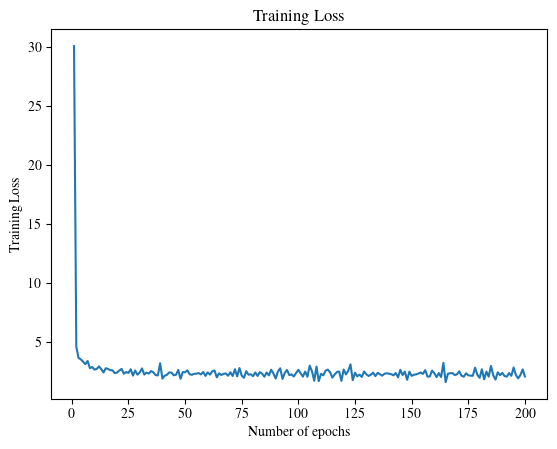

In [16]:
# Plotting the training loss
#plt.plot(range(1, params['epochs']+1), train_loss)
plt.plot(range(1, params["epochs"]+1), train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss")
plt.show()

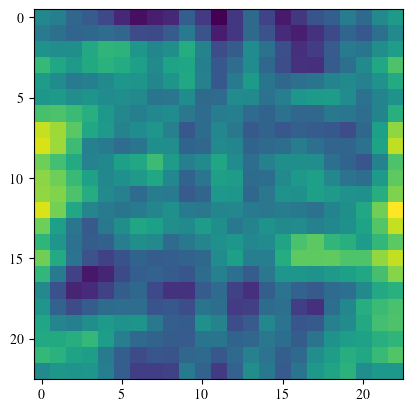

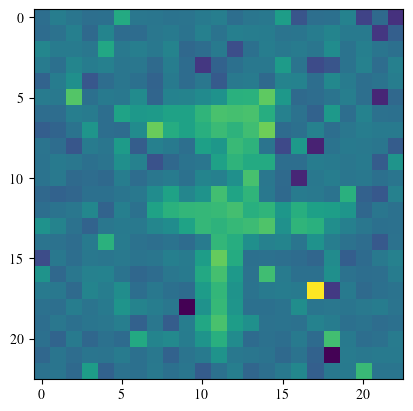

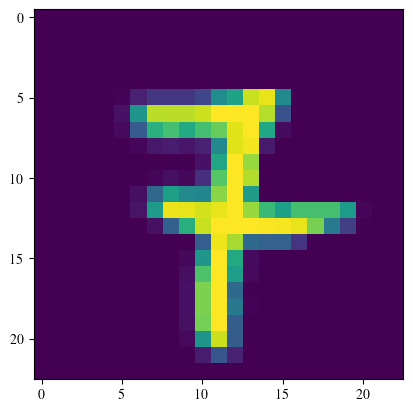

In [18]:
idx = 200
plt.imshow(torch.reshape(outputs[idx]['img'][10], (model.img_size, model.img_size))); plt.show()
plt.imshow(torch.reshape(outputs[idx]['out'].detach()[10], (model.img_size, model.img_size))); plt.show()
plt.imshow(torch.reshape(outputs[idx]['label'][10], (model.img_size, model.img_size))); plt.show()

# Code for test set evaluation that I need to modify

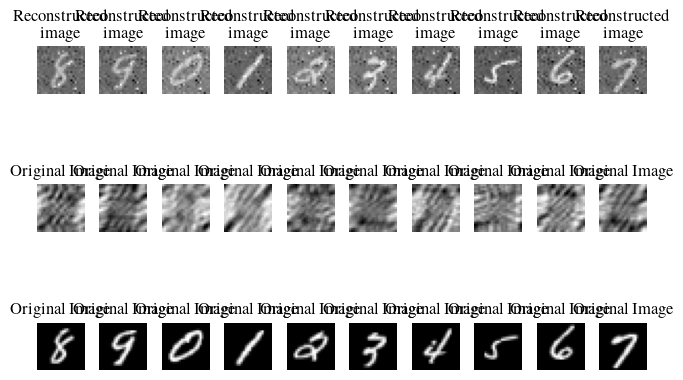

In [38]:
# Dictionary that will store the different
# images and outputs for various epochs
test_outputs = {}
  
# Extracting the last batch from the test 
# dataset
img_batch, label_batch = list(loaders['test'])[-1]
  
# Reshaping into 1d vector
img_batch = img_batch.reshape(-1, model.img_size * model.img_size)
  
# Generating output for the obtained batch
out = model(img_batch)
  
# Storing information in dictionary
test_outputs['img'] = img_batch
test_outputs['out'] = out
test_outputs['label'] = label_batch

# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = test_outputs['out'].detach().numpy()
  
# Plotting first 10 images of the batch
for idx in range(10):
    plt.subplot(3, 10, counter)
    plt.title("Reconstructed \n image")
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['img']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting label images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['label']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()